In [1]:
import pandas as pd
import os
from tqdm import tqdm
from sportypy.surfaces import MiLBField
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import find_peaks
from plotting import plot_animation

In [2]:
base = '/Users/eddie/SMT-Data-Challenge/Combined/'

In [3]:
game_events = pd.read_parquet(base + 'game_events.parquet')
game_info = pd.read_parquet(base + 'game_info.parquet')
team_info = pd.read_parquet(base + 'team_info.parquet')

In [4]:
game_events.sort_values(by=['game_str', 'timestamp', 'event_code'], inplace = True)

In [5]:
df = []

for subdir, dirs, files in os.walk(base + 'ball_pos/'):
    for file in files:
        sub_df = pd.read_parquet(base + 'ball_pos/' + file)
        df.append(sub_df)

ball_pos = pd.concat(df, ignore_index=True)

In [6]:
df = []  

for subdir, dirs, files in os.walk(base + 'player_pos/'):
    for file in tqdm(files, desc='Processing File'):
        sub_df = pd.read_parquet(base + 'player_pos/' + file, engine='fastparquet')
        df.append(sub_df)

player_pos = pd.concat(df, ignore_index=True)

Processing File: 100%|████████████████████████| 338/338 [00:06<00:00, 52.21it/s]
Processing File: 0it [00:00, ?it/s]


# Data Notes:
* Game ##.5 indicates a double header and that is the second game.
* All home teams are within the same farm system.
* Home 4A is highest and 1A is the lowest.
* 1883 season is only half a season and 1884 is a full season.
* Play ids **reset** every game

*player position codes*
```
{
    1. pitcher
    2. catcher
    3. 1st Baseman
    4. 2nd Baseman
    5. Third baseman
    6. Shortstop
    7. Left Field
    8. Center Field
    9. Right Field
    10. Batter
    11. Runner on first
    12. Runner on second
    13. Runner on third
    255. Ball event with no player (past ball)
}
```

*event codes*:
```
{
    1. Pitch thrown
    2. Ball acquired
    3. Throw for ball in play
    4. Ball hit into play
    5. End of play
    6. Pickoff Throw
    7. Ball acquired: Unknown field position
    8. Throw for ball in play: Unknown field position
    9. Ball deflection
    10. Ball deflection off wall
    11. Home run
    16. Ball bounce
}
```
Question at hand: This year’s dataset will consist of multiple teams within a single farm system. We want you to consider a situation that compares, players, teams, and/or game play at two or more levels.

In [7]:
# Decode the Game Events

PLAYER_POSITION = {
1: 'P',
2: 'C',
3: '1B',
4: '2B',
5: '3B',
6: 'SS',
7: 'LF',
8: 'CF',
9: 'RF',
10: 'BA', # The batter
11: 'R1B', # Runner on 1B
12: 'R2B', # Runner on 2B
13: 'R3B', # Runner on 3B
255: 'NA' # Ball event with no player
}

EVENT_CODE = {
    1: 'Pitch',
    2: 'Fielded', # fielded ball
    3: 'Throw', # ball thrown
    4: 'In Play',
    5: 'End of Play',
    6: 'Pickoff',
    7: 'Fielded (Unknown)',
    8: 'Throw (Unknown)',
    9: 'Ball Deflection',
    10: 'Off Wall', # we will note off wall plays are not considered
    11: 'HR',
    16: 'Ball Bounce' # Can bounce multiple times
}

game_events['player_position'] = game_events['player_position'].map(PLAYER_POSITION)
game_events['event_code'] = game_events['event_code'].map(EVENT_CODE)

In [8]:
outfield_positions = ['CF', 'RF', 'LF']

game_events['is_flyout'] = np.where(
    (game_events['player_position'].isin(outfield_positions)) & 
    (game_events['event_code'].isin(['Fielded', 'Ball Deflection'])) & # Want ball deflections as they could be fielding errors but an attempt by the outfielder to get to the ball.
    (game_events['event_code'].shift(1) == 'In Play'), 1, 0
)

In [9]:
# Want to try to get plays where the oufielder almost gets to the ball but not quite makes it
game_events['almost_caught'] = np.where(
    (game_events['player_position'].isin(outfield_positions)) & 
    (game_events['event_code'].isin(['Fielded', 'Ball Deflection'])) & 
    (game_events['event_code'].shift(1) == 'Ball Bounce') & 
    (game_events['event_code'].shift(2) == 'In Play'), 1, 0
)

In [10]:
game_events[game_events['almost_caught'] == 1]

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,is_flyout,almost_caught
56081,1883_001_Vis1AB_Home1A,264,70.0,264,9109565,RF,Fielded,0,1
53082,1883_001_Vis4AB_Home4A,31,6.0,31,772202,RF,Fielded,0,1
53167,1883_001_Vis4AB_Home4A,52,13.0,52,1577702,CF,Fielded,0,1
50820,1883_002_Vis4AB_Home4A,85,21.0,85,2814736,CF,Fielded,0,1
51148,1883_002_Vis4AB_Home4A,171,42.0,171,5616836,LF,Fielded,0,1
...,...,...,...,...,...,...,...,...,...
212534,1884_142_Vis4BE_Home4A,82,25.0,82,2671159,CF,Fielded,0,1
213059,1884_142_Vis4BE_Home4A,226,60.0,227,8164459,LF,Fielded,0,1
213141,1884_142_Vis4BE_Home4A,248,68.0,250,9170209,LF,Fielded,0,1
211150,1884_143_Vis4BE_Home4A,8,2.0,7,182100,RF,Fielded,0,1


In [11]:
game_events[game_events['is_flyout'] == 1]

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,is_flyout,almost_caught
55093,1883_001_Vis1AB_Home1A,2,1.0,2,73273,CF,Fielded,1,0
55100,1883_001_Vis1AB_Home1A,4,2.0,4,119873,LF,Fielded,1,0
55281,1883_001_Vis1AB_Home1A,49,12.0,49,1624623,CF,Fielded,1,0
55291,1883_001_Vis1AB_Home1A,52,13.0,52,1704123,LF,Fielded,1,0
55350,1883_001_Vis1AB_Home1A,66,16.0,66,2067123,RF,Fielded,1,0
...,...,...,...,...,...,...,...,...,...
212043,1884_143_Vis4BE_Home4A,253,62.0,252,8606500,LF,Fielded,1,0
212102,1884_143_Vis4BE_Home4A,268,67.0,267,9346300,RF,Fielded,1,0
212127,1884_143_Vis4BE_Home4A,274,69.0,273,9621300,CF,Fielded,1,0
212154,1884_143_Vis4BE_Home4A,281,71.0,280,9770950,RF,Fielded,1,0


In [12]:
batter = player_pos[player_pos['player_position'] == 10].copy()

first_field_x = batter.groupby(['game_str', 'play_id'])['field_x'].transform('first')
batter['handedness'] = np.where(first_field_x > 0, 'L', 'R')
handedness_df = batter.groupby(['game_str', 'play_id'])['handedness'].first().reset_index()

player_pos = player_pos.merge(handedness_df, on=['game_str', 'play_id'], how='left')



In [13]:
hit = game_events[game_events['event_code'] == 'In Play'].rename(columns = {'timestamp' : 'start_time'})
# Start time = when the ball is hit into play

fielded = game_events[(game_events['is_flyout'] == 1) | (game_events['almost_caught'] == 1)]

In [14]:
filter_v = pd.merge(fielded, hit, on = ['game_str', 'play_id'], how = 'inner', suffixes = ('', '_hit')).rename(columns={'timestamp' : 'end_time'})


In [15]:
def fill_game_state(row):
    return (
        ('1' if pd.notna(row['first_baserunner']) else '0') + 
        ('1' if pd.notna(row['second_baserunner']) else '0') +
        ('1' if pd.notna(row['third_baserunner']) else '0')
    )


In [16]:
filter_v = filter_v.iloc[:,:-3]
filter_v.drop(['at_bat_hit', 'play_per_game_hit', 'is_flyout'], axis = 1, inplace=True)

player_ids = game_info[['game_str', 'play_per_game', 'inning', 'at_bat', 'top_bottom', 'left_field', 'center_field', 'right_field']]
player_ids['game_state'] = (game_info[['first_baserunner', 'second_baserunner', 'third_baserunner']]
                            .apply(fill_game_state, axis = 1))

filter_v = pd.merge(filter_v, player_ids, on = ['game_str', 'at_bat', 'play_per_game'], how = 'inner')

filter_v[['left_field', 'center_field', 'right_field']] = filter_v.groupby(['game_str', 'top_bottom'])[['left_field', 'center_field', 'right_field']].ffill()

# Filling in player ids
filter_v['player_id'] = np.where(
    filter_v['player_position'] == 'LF', filter_v['left_field'],
    np.where(
        filter_v['player_position'] == 'CF', filter_v['center_field'],
        filter_v['right_field']
    )
)

filter_v.drop(columns=['top_bottom', 'left_field', 'center_field', 'right_field'], inplace=True)


/var/folders/0m/p03jcv9j4td3thddmd99m0300000gp/T/ipykernel_71709/228340247.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_ids['game_state'] = (game_info[['first_baserunner', 'second_baserunner', 'third_baserunner']]


In [17]:
filter_v

,game_str,play_id,at_bat,play_per_game,end_time,player_position,event_code,almost_caught,start_time,player_position_hit,inning,game_state,player_id
0,1883_001_Vis1AB_Home1A,2,1.0,2,73273,CF,Fielded,0,67773,BA,1,000,594.0
1,1883_001_Vis1AB_Home1A,4,2.0,4,119873,LF,Fielded,0,114723,BA,1,000,492.0
2,1883_001_Vis1AB_Home1A,49,12.0,49,1624623,CF,Fielded,0,1621073,BA,2,000,NaN
3,1883_001_Vis1AB_Home1A,52,13.0,52,1704123,LF,Fielded,0,1700073,BA,2,000,NaN
4,1883_001_Vis1AB_Home1A,66,16.0,66,2067123,RF,Fielded,0,2062623,BA,3,000,537.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4794,1884_143_Vis4BE_Home4A,253,62.0,252,8606500,LF,Fielded,0,8602800,BA,7,110,2188.0
4795,1884_143_Vis4BE_Home4A,268,67.0,267,9346300,RF,Fielded,0,9343100,BA,8,100,502.0
4796,1884_143_Vis4BE_Home4A,274,69.0,273,9621300,CF,Fielded,0,9616000,BA,8,000,8801.0
4797,1884_143_Vis4BE_Home4A,281,71.0,280,9770950,RF,Fielded,0,9765150,BA,8,000,6466.0


In [18]:
outfielders = player_pos[player_pos['player_position'].isin([7, 8, 9])].copy()
outfielders['player_position'] = outfielders['player_position'].map(PLAYER_POSITION)

In [19]:
player_pos_out = pd.merge(filter_v, outfielders, left_on=['game_str', 'play_id', 'start_time', 'player_position'], right_on = ['game_str', 'play_id', 'timestamp', 'player_position'], how='left').drop('timestamp', axis = 1)



In [20]:
ball_pos_out = pd.merge(filter_v, ball_pos, left_on=['game_str', 'play_id', 'end_time'], right_on = ['game_str', 'play_id', 'timestamp'], how='left').drop('timestamp', axis = 1)
ball_pos_out = ball_pos_out[['game_str', 'play_id', 'at_bat', 'ball_position_x', 'ball_position_y', 'ball_position_z']]


# Removed about 36 rows that were bad data
final = pd.merge(player_pos_out, ball_pos_out, on = ['game_str', 'play_id', 'at_bat'], how = 'left').dropna(subset = ['field_x', 'ball_position_x'])


In [21]:
# Find maximum player location
max_out_location = outfielders.loc[outfielders.groupby(['game_str', 'play_id', 'player_position'])['timestamp'].idxmax(), 
                ['game_str', 'play_id', 'player_position', 'field_x', 'field_y']].rename(columns={
    'field_x': 'field_end_x', 'field_y': 'field_end_y'})

In [22]:
def derive_hitting_metrics(df):
    dx = df.groupby(['game_str', 'play_id'])['ball_position_x'].diff() 
    dy = df.groupby(['game_str', 'play_id'])['ball_position_y'].diff()
    dz = df.groupby(['game_str', 'play_id'])['ball_position_z'].diff()

    # Timestamp diff
    dt = df.groupby(['game_str', 'play_id'])['timestamp'].diff()

    # velocity vectors
    vx = dx / dt
    vy = dy / dt
    vz = dz / dt

    # Exit velocity = magnitude of the displacement vectors
    df['exit_velocity'] = (np.sqrt(vx**2 + vy**2 + vz**2)) * 3600000 / 5280 # miles per hour
    # Inverse tan of the perpendicular (z coordinate) / base (distance between x and y vectors)
    # (-) z coordinates so take the absolute value of them.
    df['launch_angle'] = np.degrees(np.arctan2(abs(vz), np.sqrt(vx**2 + vy**2)))

    return df


In [23]:
# Find the timestamps where the ball makes contact then derive the launch angle and exit velo
# First I need to find the timestamp of the hit then derive the difference of the next two timestamps.
# In filter_v start time = what I want. Just need the next 2

contact_df = ball_pos.merge(filter_v, left_on = ['game_str', 'play_id'], right_on = ['game_str', 'play_id'], how = 'inner')
contact_df = contact_df[(contact_df['timestamp'] >= contact_df['start_time']) &
                       (contact_df['end_time'] >= contact_df['timestamp'])]
contact_df = derive_hitting_metrics(contact_df)

# 2nd to 10 observation to eliminate possible error from initial hit.
# I simply use this article to reference what the exit velo should look like for MLB hitters on fly balls.
# https://jona.substack.com/p/fly-ball-exit-velocity-breakdown
contact_df = contact_df.groupby(['game_str', 'play_id'])[['exit_velocity', 'launch_angle']].apply(lambda x: x.iloc[1:11].mean()).reset_index()



In [24]:
final = pd.merge(final, contact_df, on = ['game_str', 'play_id'], how = 'left')
final = pd.merge(final, max_out_location, on = ['game_str', 'play_id', 'player_position'], how = 'left')
   

In [25]:
# This filters plays where an outfielder fields the ball, a total of 4,758 observations.
final

,game_str,play_id,at_bat,play_per_game,end_time,player_position,event_code,almost_caught,start_time,player_position_hit,...,field_x,field_y,handedness,ball_position_x,ball_position_y,ball_position_z,exit_velocity,launch_angle,field_end_x,field_end_y
0,1883_001_Vis1AB_Home1A,2,1.0,2,73273,CF,Fielded,0,67773,BA,...,-5.6358,308.5794,R,-16.98135,329.4720,4.787370,82.100106,34.341242,-18.0411,328.0791
1,1883_001_Vis1AB_Home1A,4,2.0,4,119873,LF,Fielded,0,114723,BA,...,-125.0325,241.4478,L,-133.04100,182.3649,4.718250,71.305441,46.826170,-131.9796,178.2810
2,1883_001_Vis1AB_Home1A,49,12.0,49,1624623,CF,Fielded,0,1621073,BA,...,-1.0332,311.2104,L,29.13606,260.8020,2.199318,68.557098,22.269331,30.5283,244.6044
3,1883_001_Vis1AB_Home1A,52,13.0,52,1704123,LF,Fielded,0,1700073,BA,...,-131.7357,266.6529,R,-89.36070,302.4690,3.871440,88.440390,21.586868,-86.8119,308.9538
4,1883_001_Vis1AB_Home1A,66,16.0,66,2067123,RF,Fielded,0,2062623,BA,...,126.2733,231.2652,R,100.18980,313.6980,6.418260,93.986909,25.099581,96.4707,330.6606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4753,1884_142_Vis4BE_Home4A,227,61.0,228,8212309,RF,Fielded,0,8206859,BA,...,131.9016,259.6098,R,125.81310,314.5740,5.314890,91.229366,33.459258,132.9711,323.6319
4754,1884_142_Vis4BE_Home4A,232,63.0,234,8477309,CF,Fielded,0,8471509,BA,...,25.4760,304.4340,R,75.99360,300.5610,5.442150,90.795184,39.728570,79.8729,300.5508
4755,1884_142_Vis4BE_Home4A,248,68.0,250,9170209,LF,Fielded,1,9167159,BA,...,-131.0262,254.2587,R,-93.63960,255.4401,5.172240,88.180098,16.707800,-87.9705,252.0558
4756,1884_142_Vis4BE_Home4A,257,71.0,259,9662709,LF,Fielded,0,9659159,BA,...,-140.7099,228.7614,L,-179.86470,219.5319,6.831900,70.640886,22.016643,-189.3228,222.6675


In [90]:
def plot_heatmap(df):
    field = MiLBField()

    plt.figure(figsize=(12, 10))

    field.draw()

    positions = ['LF', 'CF', 'RF']

    for position in positions:
        position_data = df[df['player_position'] == position]
        sns.kdeplot(
            x=position_data['ball_position_x'],
            y=position_data['ball_position_y'],
            cmap='magma',
            alpha=0.6,
            fill = True,
            levels = 8,
            ax=plt.gca()
        )

        plt.text(position_data.field_x.mean(), position_data.field_y.mean(), 
                 position, fontsize=12, ha='center', color='black', fontweight = 'bold')

    plt.title('Heatmap of Flyball Attempts by Outfielders', c = 'w')

    plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

<Figure size 1200x1000 with 0 Axes>

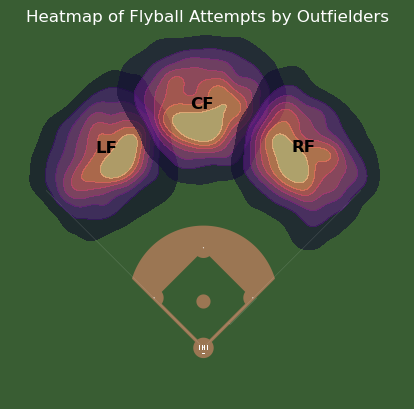

In [91]:
plot_heatmap(final)

In [92]:
# 94,499 events

(4758 / 94499) * 100
# About 5% of our plays are flyball attempts.

5.0349739150678845

# Steps to Take

Identify how to make a range map. Essentially, it will be for **any** fly ball so I will need to find where a player is in their starting position then where they end up on the field. You draw a line with opacity to it and it should output something like this: [Outfield](https://grantland.com/the-triangle/2014-mlb-playoffs-exploiting-kansas-city-royals-ultimate-outfield-jarrod-dyson-alex-gordon-lorenzo-cain/) This is going to be used for route efficiency.

Here's what the model will be initially:
* Input features like hang time, angle to the ball, etc.
* Outputs the expected time for a player to reach the ball.
* Compare it throughout the different leagues to see what players are getting to the ball.
* Once I have it, I could make a hexbin plot of where players are strong suited to where they may get to the ball from the outfield.
* *Maybe* normalize it?

TODO:
1. I may add a beizer curve as an input feature to see if the curvier the route, the more distance required to get to the ball which I'm not sure. [Beizer curve guess](https://javascript.info/bezier-curve)
2. Fix the Exit Velocity computation to get a more accurate measure.
3. Compute the second control point to test model. It will be the second largest distance.


In [26]:
def linear_points(df):
    def fill_na_in_group(group, field_x, field_y):
        """
        The strategy here is to locate the first and last x and y fielder coordinates
        then fill the values in between as NA then interpolate those NA values filling them linearly.
        """

        group.loc[:, 'linear_x'] = np.nan
        group.loc[:, 'linear_y'] = np.nan
        first = group.index[0]
        last = group.index[-1]
        group.loc[first, 'linear_x'] = group.loc[first, field_x]
        group.loc[last, 'linear_x'] = group.loc[last, field_x]

        group.loc[first, 'linear_y'] = group.loc[first, field_y]
        group.loc[last, 'linear_y'] = group.loc[last, field_y]

        group['linear_x'] = group['linear_x'].interpolate(method='linear')
        group['linear_y'] = group['linear_y'].interpolate(method='linear')
        return group

    return (df.groupby(['game_str', 'play_id']).apply(fill_na_in_group, 'field_x_int', 'field_y_int')
            .reset_index(drop = True))

In [27]:
actual_routes = pd.merge(final, outfielders, on = ['game_str', 'play_id', 'player_position'], how = 'left', suffixes = ('', '_int'))
actual_routes = linear_points(actual_routes)

values = []
for (game_str, play_id), play in tqdm(actual_routes.groupby(['game_str', 'play_id']), desc = 'Extracting distance'):
    play['x_diff'] = play['field_x_int'].diff().fillna(0)
    play['y_diff'] = play['field_y_int'].diff().fillna(0)

    play['timestamp'] = play['timestamp'] / 1000

    play['time_diff'] = play['timestamp'].diff().fillna(0)

    play['stepwise_diff'] = np.sqrt(play['x_diff']**2 + play['y_diff'] ** 2)

    play['speed'] = play['stepwise_diff'] / play['time_diff']

    distance = np.sum(play['stepwise_diff'])

    max_speed = play['speed'].max()
    mean_speed =  play['speed'].mean()


    # First compute the maximum distance difference on perpendicular plane.
    play['perp_distance'] = abs(play['linear_y'] - play['field_y_int']) # Only really care about the max distance between y values for perpendicular.
    peaks, _ = find_peaks(play['perp_distance'], height = 1) # Returns indicies of peaks
    troughs, _ = find_peaks(-play['perp_distance'], height = 1) # Returns indicies of troughs
    p_t = np.concatenate((peaks, troughs))

    if len(p_t) < 2:
        largest_peak = play['perp_distance'].nlargest(1).index[0]
        second_peak = play['perp_distance'].nlargest(2).index[1]
    else:
        largest_peak = play['perp_distance'].iloc[p_t].nlargest(1).index[0]
        second_peak = play['perp_distance'].iloc[p_t].nlargest(len(p_t)).index[-1] # Let's index the last one of p_t



    p1_x, p1_y = play.loc[largest_peak, ['field_x_int', 'field_y_int']]
    p2_x, p2_y = play.loc[second_peak, ['field_x_int', 'field_y_int']]

    # Gonna move these points so it's further out and won't impede the curvature
    x_distance = p1_y / play['field_y_int'].iloc[-1] # % of route
    y_distance = p1_x / play['field_x_int'].iloc[-1]
    
    d1x = p1_x - play.loc[largest_peak, 'linear_x']
    d1y = p1_y - play.loc[largest_peak, 'linear_y']
    d2x = p2_x - play.loc[second_peak, 'linear_x']
    d2y = p2_y - play.loc[second_peak, 'linear_y']

    d1x_dir = np.sign(d1x)
    d1y_dir = np.sign(d1y)
    d2x_dir = np.sign(d2x)
    d2y_dir = np.sign(d2y)
    

    p1_x = p1_x + d1x_dir * x_distance
    p2_x = p2_x + d2x_dir * x_distance
    p1_y = p1_y + d1y_dir * y_distance
    p2_y = p2_y + d2y_dir * y_distance
    
    # Check if the p2_x is closer to the start than p1_x
    if abs(p1_x - play['field_x_int'].iloc[1]) > abs(p2_x - play['field_x_int'].iloc[1]): # Swap them
        temp_x = p1_x
        temp_y = p1_y
        p1_x = p2_x
        p1_y = p2_y
        p2_x = temp_x
        p2_y = temp_y
        


    # Convert the initial angle into a 0-360 degree plane
    # Broken down into 4 quadrants
    y_coord = play['field_y_int'].iloc[26]- play['field_y_int'].iloc[1]
    x_coord = play['field_x_int'].iloc[26] - play['field_x_int'].iloc[1]

    angle = (np.degrees(np.arctan2(y_coord, x_coord)) - 90) % 360 # Ensure it's all positive
    # Now I need the compute the angle to the ball and take the difference on how off they were 
    # Spray angle will be used as a way to quantify where the fielder is with respect to the ball
    # So it will serve as an error metric.
    spray_angle = (np.degrees(np.arctan2(play['field_x_int'].iloc[-1], play['field_y_int'].iloc[-1])))

    values.append({'game_str': game_str, 'play_id': play_id,
                      'actual_distance': distance, 'max_speed': max_speed, 'mean_speed': mean_speed,
                    'p1_x' : p1_x, 'p1_y' : p1_y, 'p2_x' : p2_x, 'p2_y' : p2_y, 'initial_angle' : angle, 
                   'spray_angle' : spray_angle})

Extracting distance: 100%|█████████████████| 4755/4755 [00:06<00:00, 702.57it/s]


In [100]:
derived_values = pd.DataFrame(values)
final = pd.merge(final, derived_values, on = ['game_str', 'play_id'], how = 'left')

(0.0, 400.0)

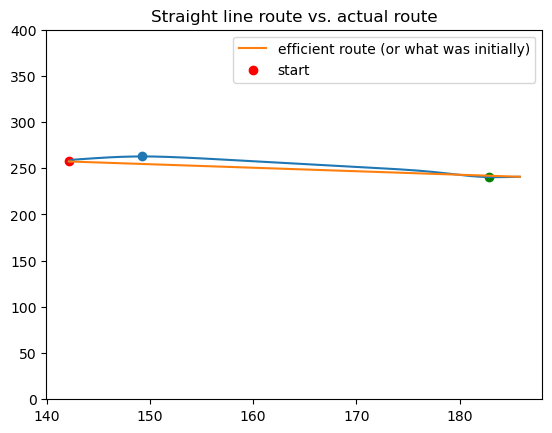

In [107]:
game = '1883_001_Vis1AB_Home1A'
play_id = 111

plot_test = actual_routes.query(f"game_str == '{game}' & play_id == {play_id}")
coords = final.query(f"game_str == '{game}' & play_id == {play_id}")
plt.plot(plot_test['field_x_int'], plot_test['field_y_int'])
plt.plot(plot_test['linear_x'], plot_test['linear_y'], label = 'efficient route (or what was initially)')
plt.scatter(coords['p1_x'], coords['p1_y'])
plt.scatter(coords['p2_x'], coords['p2_y'], c='g')
plt.scatter(plot_test['field_x_int'].iloc[0], plot_test['field_y_int'].iloc[0], color='r', label = 'start')
plt.legend(loc= 'best')
plt.title('Straight line route vs. actual route')
#plt.xlim(-20, 20)

plt.ylim(0, 400)

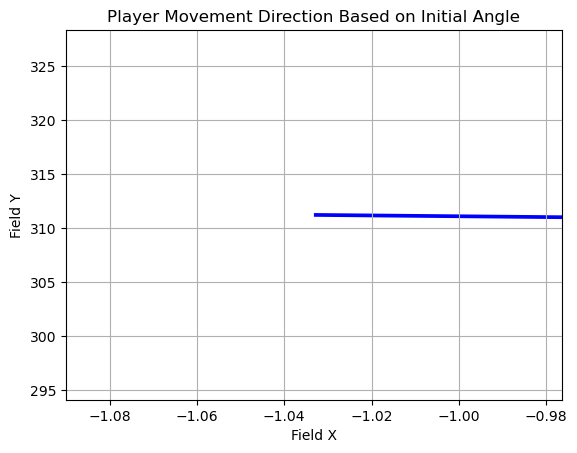

In [52]:
test = final[(derived_values['game_str'] == '1883_001_Vis1AB_Home1A') & 
             (final['play_id'] == 49)]

angles_radians = np.radians(test['initial_angle'])

u = np.cos(angles_radians)
v = np.sin(angles_radians)


plt.quiver(test['field_x'], test['field_y'], u, v, angles='xy', scale_units='xy', scale=1, color='b')
plt.xlabel('Field X')
plt.ylabel('Field Y')
plt.title('Player Movement Direction Based on Initial Angle')
plt.grid(True)
#plt.xlim(-10, 5)
plt.show()


In [108]:
final['straight_line'] = np.sqrt((final['field_end_x'] - final['field_x']) ** 2 + 
                                (final['field_end_y'] - final['field_y']) ** 2)


final['route_efficiency'] = final['straight_line'] / final['actual_distance']

final['max_player_speed'] = final.groupby('player_id')['mean_speed'].transform('max')

final['max_player_speed'].fillna(12.877761, inplace = True) # gonna fill in with the median speed

final['actual_time'] = (final['end_time'] - final['start_time']) / 1000

In [109]:
final.isna().sum()

game_str                 0
play_id                  0
at_bat                 185
play_per_game            0
end_time                 0
player_position          0
event_code               0
almost_caught            0
start_time               0
player_position_hit      0
inning                   0
game_state               0
player_id              547
field_x                  0
field_y                  0
handedness               0
ball_position_x          0
ball_position_y          0
ball_position_z          0
exit_velocity            0
launch_angle             0
field_end_x              0
field_end_y              0
actual_distance          0
max_speed                0
mean_speed               0
p1_x                     0
p1_y                     0
p2_x                     0
p2_y                     0
initial_angle            0
spray_angle              0
straight_line            0
route_efficiency         0
max_player_speed         0
actual_time              0
dtype: int64

In [55]:
final.query('launch_angle < 10')[['almost_caught', 'launch_angle', 'actual_time', 'exit_velocity']]


,almost_caught,launch_angle,actual_time,exit_velocity
17,1,7.989130,3.10,100.248764
27,0,0.917961,4.70,47.731653
71,1,7.107892,2.55,92.397044
77,1,7.507348,2.75,102.779006
111,1,9.207964,2.75,93.522736
...,...,...,...,...
4717,1,6.543579,2.65,102.708327
4725,1,9.097251,2.80,98.878739
4732,1,2.317051,4.00,89.466089
4748,1,8.985302,3.05,94.518293


<Axes: >

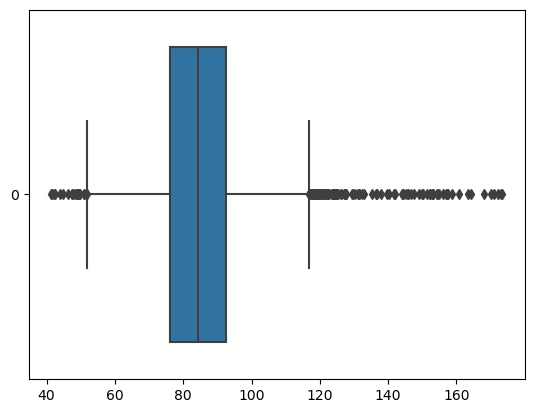

In [56]:
sns.boxplot(final.query('launch_angle > 10')['exit_velocity'], orient='h')

<Axes: >

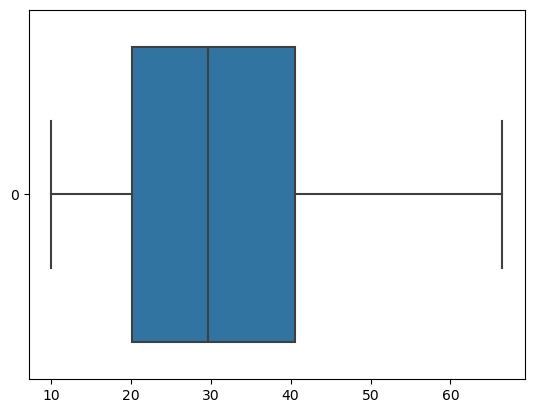

In [57]:
sns.boxplot(final.query('launch_angle > 10')['launch_angle'], orient='h')

In [110]:
# Gonna remove bad data for launch angle

# As a guideline, here are the Launch Angles for different types of contact:

# Ground ball: Less than 10 degrees
# Line drive: 10-25 degrees
# Fly ball: 25-50 degrees
# Pop up: Greater than 50 degrees


final = final.query('launch_angle > 10')

In [111]:
final['league'] = final['game_str'].apply(lambda x: x.split('_')[-1])
final['handedness_encode'] = final['handedness'].map({'L' : 0, 'R' : 1}) # Batter handedness


In [112]:
final.groupby(['player_position', 'league'])['initial_angle'].median()

player_position  league
CF               Home1A    180.709013
                 Home2A    183.485948
                 Home3A    178.173713
                 Home4A    170.462367
LF               Home1A    204.055850
                 Home2A    206.456308
                 Home3A    202.788169
                 Home4A    195.262656
RF               Home1A    163.570623
                 Home2A    158.522407
                 Home3A    152.398145
                 Home4A    163.429631
Name: initial_angle, dtype: float64

In [61]:
final.groupby(['player_position', 'game_state'])['initial_angle'].median().reset_index()

,player_position,game_state,initial_angle
0,CF,000,177.506838
1,CF,001,185.317287
2,CF,010,181.998985
3,CF,011,171.580085
4,CF,100,174.402348
5,CF,101,180.565615
6,CF,110,173.818132
7,CF,111,179.808090
8,LF,000,202.065030
9,LF,001,202.832254


In [113]:
final.describe()

,play_id,at_bat,play_per_game,end_time,almost_caught,start_time,inning,player_id,field_x,field_y,...,p1_y,p2_x,p2_y,initial_angle,spray_angle,straight_line,route_efficiency,max_player_speed,actual_time,handedness_encode
count,4649.000000,4465.000000,4649.000000,4.649000e+03,4649.000000,4.649000e+03,4649.000000,4115.000000,4649.000000,4649.000000,...,4649.000000,4649.000000,4649.000000,4649.000000,4649.000000,4649.000000,4649.000000,4649.000000,4649.000000,4649.000000
mean,142.657346,38.034714,143.854377,4.967018e+06,0.128630,4.962497e+06,4.638847,3121.371081,-0.443901,270.979821,...,270.579686,-1.222883,269.123352,176.019857,-0.169918,57.645979,0.801698,13.496504,4.521339,0.519251
std,86.184075,22.455659,86.850831,4.376571e+06,0.334826,4.376566e+06,2.657622,3077.562752,98.415392,30.114579,...,33.056859,102.784142,46.623877,87.964617,23.066418,25.909743,0.170516,3.323707,1.109594,0.499683
min,1.000000,0.000000,1.000000,1.087300e+04,0.000000,6.323000e+03,0.000000,334.000000,-174.922800,200.643000,...,128.048648,-228.737695,117.258565,0.158275,-51.556632,0.559089,0.017571,2.221955,2.150000,0.000000
25%,71.000000,19.000000,72.000000,2.298441e+06,0.000000,2.293691e+06,2.000000,537.000000,-114.188400,245.825400,...,244.987629,-100.433993,238.496166,122.117178,-18.151516,38.577730,0.734851,11.081287,3.600000,0.000000
50%,137.000000,37.000000,138.000000,4.561981e+06,0.000000,4.556481e+06,5.000000,975.000000,-6.169200,261.607500,...,262.298954,-3.421537,265.805466,177.878904,-0.541471,56.407571,0.853573,12.877761,4.550000,1.000000
75%,210.000000,56.000000,212.000000,7.253511e+06,0.000000,7.247497e+06,7.000000,5395.000000,117.484800,300.766800,...,301.026702,96.860333,304.087374,227.416915,17.713836,75.231434,0.922122,16.118212,5.400000,1.000000
max,429.000000,106.000000,431.000000,8.749607e+07,1.000000,8.749202e+07,12.000000,9957.000000,176.677200,348.089400,...,383.725142,233.067851,412.324978,359.504558,51.380771,151.203139,0.997705,20.883444,10.650000,1.000000


# For analysis, this graph will need to be rotated 90 degrees.

/var/folders/0m/p03jcv9j4td3thddmd99m0300000gp/T/ipykernel_41536/3573291982.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['league'] = final['game_str'].apply(lambda x: x.split('_')[-1])
/var/folders/0m/p03jcv9j4td3thddmd99m0300000gp/T/ipykernel_41536/3573291982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['handedness_encode'] = final['handedness'].map({'L' : 0, 'R' : 1}) # Batter handedness
/var/folders/0m/p03jcv9j4td3thddmd99m0300000gp/T/ipykernel_41536/3573291982.py:6: MatplotlibD

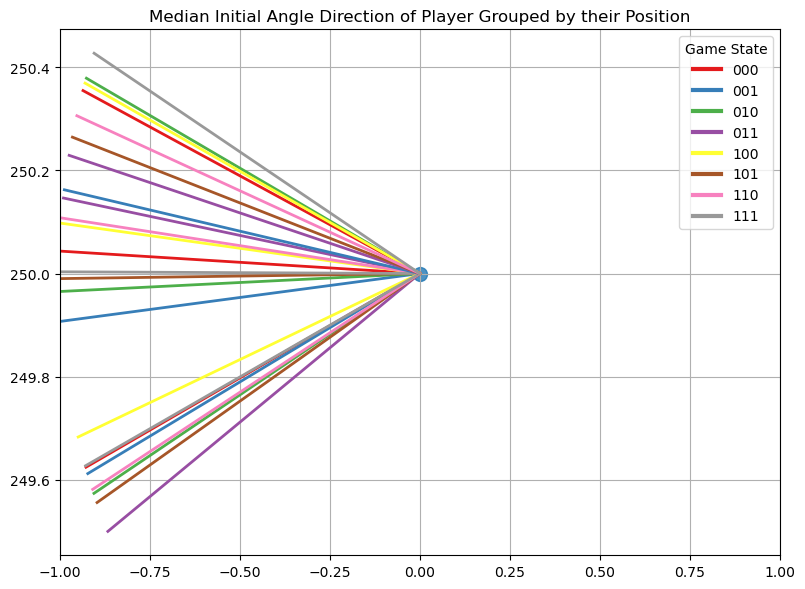

In [119]:
final['league'] = final['game_str'].apply(lambda x: x.split('_')[-1])
final['handedness_encode'] = final['handedness'].map({'L' : 0, 'R' : 1}) # Batter handedness

pos_angles = final.groupby(['player_position', 'game_state'])['initial_angle'].median().reset_index()
unique_states = pos_angles['game_state'].unique()
cmap = plt.cm.get_cmap('Set1', len(unique_states)) 


plt.figure(figsize=(8, 6))
plt.scatter(0, 250, s=100, alpha=0.8)
for index, row in pos_angles.iterrows():
    start_x = 0
    start_y = 250
    angle_rad = np.radians(row['initial_angle'])
    end_x = start_x + np.cos(angle_rad)
    end_y = start_y + np.sin(angle_rad)
    color = cmap(np.where(unique_states == row['game_state'])[0][0])
    plt.plot([start_x, end_x], [start_y, end_y], color=color, linewidth=2, label=row['game_state'])
plt.title('Median Initial Angle Direction of Player Grouped by their Position')
plt.grid(True)
plt.tight_layout()
handles = [plt.Line2D([0, 1], [0, 0], color=cmap(i), linewidth=3) for i in range(len(unique_states))]
plt.legend(handles, unique_states, title='Game State', loc='best')
plt.xlim(-1, 1)
plt.show()

In [63]:
final.groupby(['player_position', 'league'])['initial_angle'].median()

player_position  league
CF               Home1A    180.709013
                 Home2A    183.485948
                 Home3A    178.173713
                 Home4A    170.462367
LF               Home1A    204.055850
                 Home2A    206.456308
                 Home3A    202.788169
                 Home4A    195.262656
RF               Home1A    163.570623
                 Home2A    158.522407
                 Home3A    152.398145
                 Home4A    163.429631
Name: initial_angle, dtype: float64

In [62]:
final.groupby(['game_state'])['route_efficiency'].mean()

game_state
000    0.827185
001    0.743240
010    0.758444
011    0.755118
100    0.757639
101    0.756100
110    0.767781
111    0.770926
Name: route_efficiency, dtype: float64

In [65]:
# This is good that there is a balance amongst the league numbers so it won't overfit to a particular league... hopefully.
final.league.value_counts()

league
Home1A    1237
Home4A    1225
Home3A    1135
Home2A    1052
Name: count, dtype: int64

In [66]:
final.player_position.value_counts()

player_position
CF    1823
LF    1430
RF    1396
Name: count, dtype: int64

In [45]:
final.player_id.value_counts().head(10)

player_id
651.0    144
475.0    141
495.0    140
963.0    134
492.0    128
892.0    111
460.0    100
435.0    100
537.0     96
975.0     86
Name: count, dtype: int64

In [52]:
s = final.player_id.value_counts().reset_index()

s[s['count'] < 5]['count'].sum()

450

In [114]:
final

,game_str,play_id,at_bat,play_per_game,end_time,player_position,event_code,almost_caught,start_time,player_position_hit,...,p2_x,p2_y,initial_angle,spray_angle,straight_line,route_efficiency,max_player_speed,actual_time,league,handedness_encode
0,1883_001_Vis1AB_Home1A,2,1.0,2,73273,CF,Fielded,0,67773,BA,...,-10.266726,337.489087,29.313795,-3.147530,23.111248,0.553842,18.968681,5.50,Home1A,1
1,1883_001_Vis1AB_Home1A,4,2.0,4,119873,LF,Fielded,0,114723,BA,...,-136.679916,236.510999,98.702407,-36.512167,63.547674,0.879348,18.278859,5.15,Home1A,0
2,1883_001_Vis1AB_Home1A,49,12.0,49,1624623,CF,Fielded,0,1621073,BA,...,13.264581,308.321065,284.994720,7.114119,73.705410,0.831447,12.877761,3.55,Home1A,0
3,1883_001_Vis1AB_Home1A,52,13.0,52,1704123,LF,Fielded,0,1700073,BA,...,-101.101284,304.103474,334.554721,-15.694655,61.705056,0.963687,12.877761,4.05,Home1A,1
4,1883_001_Vis1AB_Home1A,66,16.0,66,2067123,RF,Fielded,0,2062623,BA,...,122.882667,238.286427,42.515138,16.264680,103.767242,0.986064,18.625452,4.50,Home1A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4752,1884_142_Vis4BE_Home4A,226,60.0,227,8164459,LF,Fielded,1,8160659,BA,...,-62.718372,223.747618,297.475792,-16.270732,76.262876,0.883119,12.154987,3.80,Home4A,0
4753,1884_142_Vis4BE_Home4A,227,61.0,228,8212309,RF,Fielded,0,8206859,BA,...,136.492319,314.673361,31.938151,22.336360,64.031032,0.921266,16.983263,5.45,Home4A,1
4754,1884_142_Vis4BE_Home4A,232,63.0,234,8477309,CF,Fielded,0,8471509,BA,...,41.358921,307.951693,338.535977,14.882643,54.535328,0.971060,17.721751,5.80,Home4A,1
4755,1884_142_Vis4BE_Home4A,248,68.0,250,9170209,LF,Fielded,1,9167159,BA,...,-87.982095,255.582058,289.774719,-19.239600,43.112018,0.944617,12.154987,3.05,Home4A,1


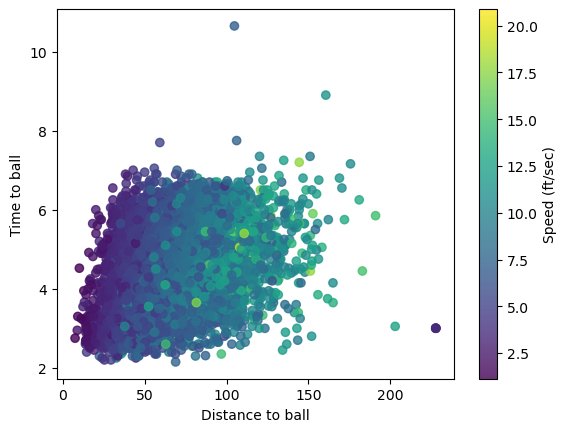

In [121]:
plt.scatter(final['actual_distance'], final['actual_time'], c= final['mean_speed'], alpha = 0.8)
plt.colorbar(label='Speed (ft/sec)')
plt.xlabel('Distance to ball')
plt.ylabel('Time to ball')
plt.show()


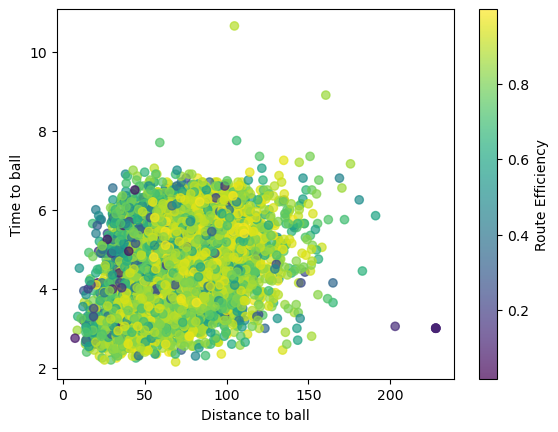

In [122]:
plt.scatter(final['actual_distance'], final['actual_time'], c= final['route_efficiency'], alpha = 0.7)
plt.colorbar(label='Route Efficiency')
plt.xlabel('Distance to ball')
plt.ylabel('Time to ball')
plt.show()

In [115]:
final.to_csv('./Clean/flyball_data.csv', index = False)

In [124]:
help(plot_animation)

Help on function plot_animation in module plotting:

plot_animation(player_position_df: pandas.core.frame.DataFrame, ball_position_df: pandas.core.frame.DataFrame, play_id: int = 1, save_gif: bool = False) -> IPython.core.display.HTML
    A function that plots field animations for a particular instance of a game.
    Example usage:
    
    ```
    player_pos = pd.read_parquet('./Combined/player_pos/1884_110_Vis2AR_Home2A.parquet')
    ball_pos = pd.read_parquet('./Combined/ball_pos/1884_110_Vis2AR_Home2A.parquet')
    
    plot_animation(player_pos, ball_pos, play_id = 30, save_gif = True)
    ```
    
    Params:
        player_position_df: A Data Frame for the player position coordinates on a field.
        ball_position_df: A Data Frame for the ball position coordiantes on a field.
        play_id: A integer field that denotes the play id you want to visualize. Defaults to 1.
        save_gif: A boolean that when set to true saves the animation to a gif. 
                  Defaults

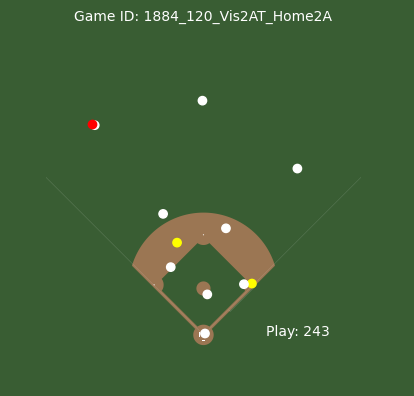

In [3]:
pp = pd.read_parquet('./Combined/player_pos/1884_120_Vis2AT_Home2A.parquet')
bp = pd.read_parquet('./Combined/ball_pos/1884_120_Vis2AT_Home2A.parquet')

plot_animation(pp, bp, play_id = 243)


In [126]:
unique_teams = team_info.groupby('player_id')['home_team'].nunique().sort_values(ascending = False).reset_index()


positions = game_info.iloc[:, 7:16]

players = {}
for position in positions.columns:
    players[position] = set(positions[position].dropna())


for position, ids in players.items():
    for id_ in ids:
        team_indices = unique_teams.index[unique_teams['player_id'] == id_].tolist()
        unique_teams.loc[team_indices, 'position'] = position

unique_teams[unique_teams['home_team'] > 1]['position'].value_counts()

position
pitcher         42
right_field     10
shortstop        7
catcher          6
center_field     5
left_field       4
third_base       4
first_base       3
second_base      2
Name: count, dtype: int64

In [127]:
unique_teams['position'].value_counts()

position
pitcher         110
right_field      27
catcher          14
shortstop        13
first_base       10
center_field     10
left_field        8
third_base        8
second_base       2
nan               1
Name: count, dtype: int64